In [1]:
import os
import uuid
import glob
import base64
import requests
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import ImageFile, Image
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)

Tensorflow version:  2.10.1
Pandas version:  2.2.3
Numpy version:  1.26.4


In [3]:
gpus= tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available:  0


In [4]:
def preprocessing_function(image):
    return tf.keras.applications.xception.preprocess_input(image)
    
def load_image_data_generator(
                            train_path: str = 'data/images/train',
                            valid_path: str = 'data/images/valid',
                            test_path: str = 'data/images/test',
                            ):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    zoom_range=0.2,
                                                                    shear_range=0.2,
                                                                    rotation_range=20,
                                                                    horizontal_flip=True,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    preprocessing_function=preprocessing_function,
                                                                    )
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    preprocessing_function=preprocessing_function
                                                                    )   

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    preprocessing_function=preprocessing_function
                                                                    )
    train_generator = train_datagen.flow_from_directory(
                                                        train_path,
                                                        batch_size=12,
                                                        color_mode='rgb',
                                                        target_size=(224, 224),
                                                        class_mode='categorical'
                                                        )   

    valid_generator = valid_datagen.flow_from_directory(
                                                    valid_path,
                                                    batch_size=12,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    class_mode='categorical'                    
                                                    )   
    
    test_generator = test_datagen.flow_from_directory(
                                                    test_path,
                                                    batch_size=12,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    class_mode='categorical',
                                                    shuffle=False
                                                    )
    return train_generator, test_generator, valid_generator

In [5]:
train_generator, test_generator, valid_generator = load_image_data_generator()

Found 1594 images belonging to 4 classes.
Found 321 images belonging to 4 classes.
Found 155 images belonging to 4 classes.


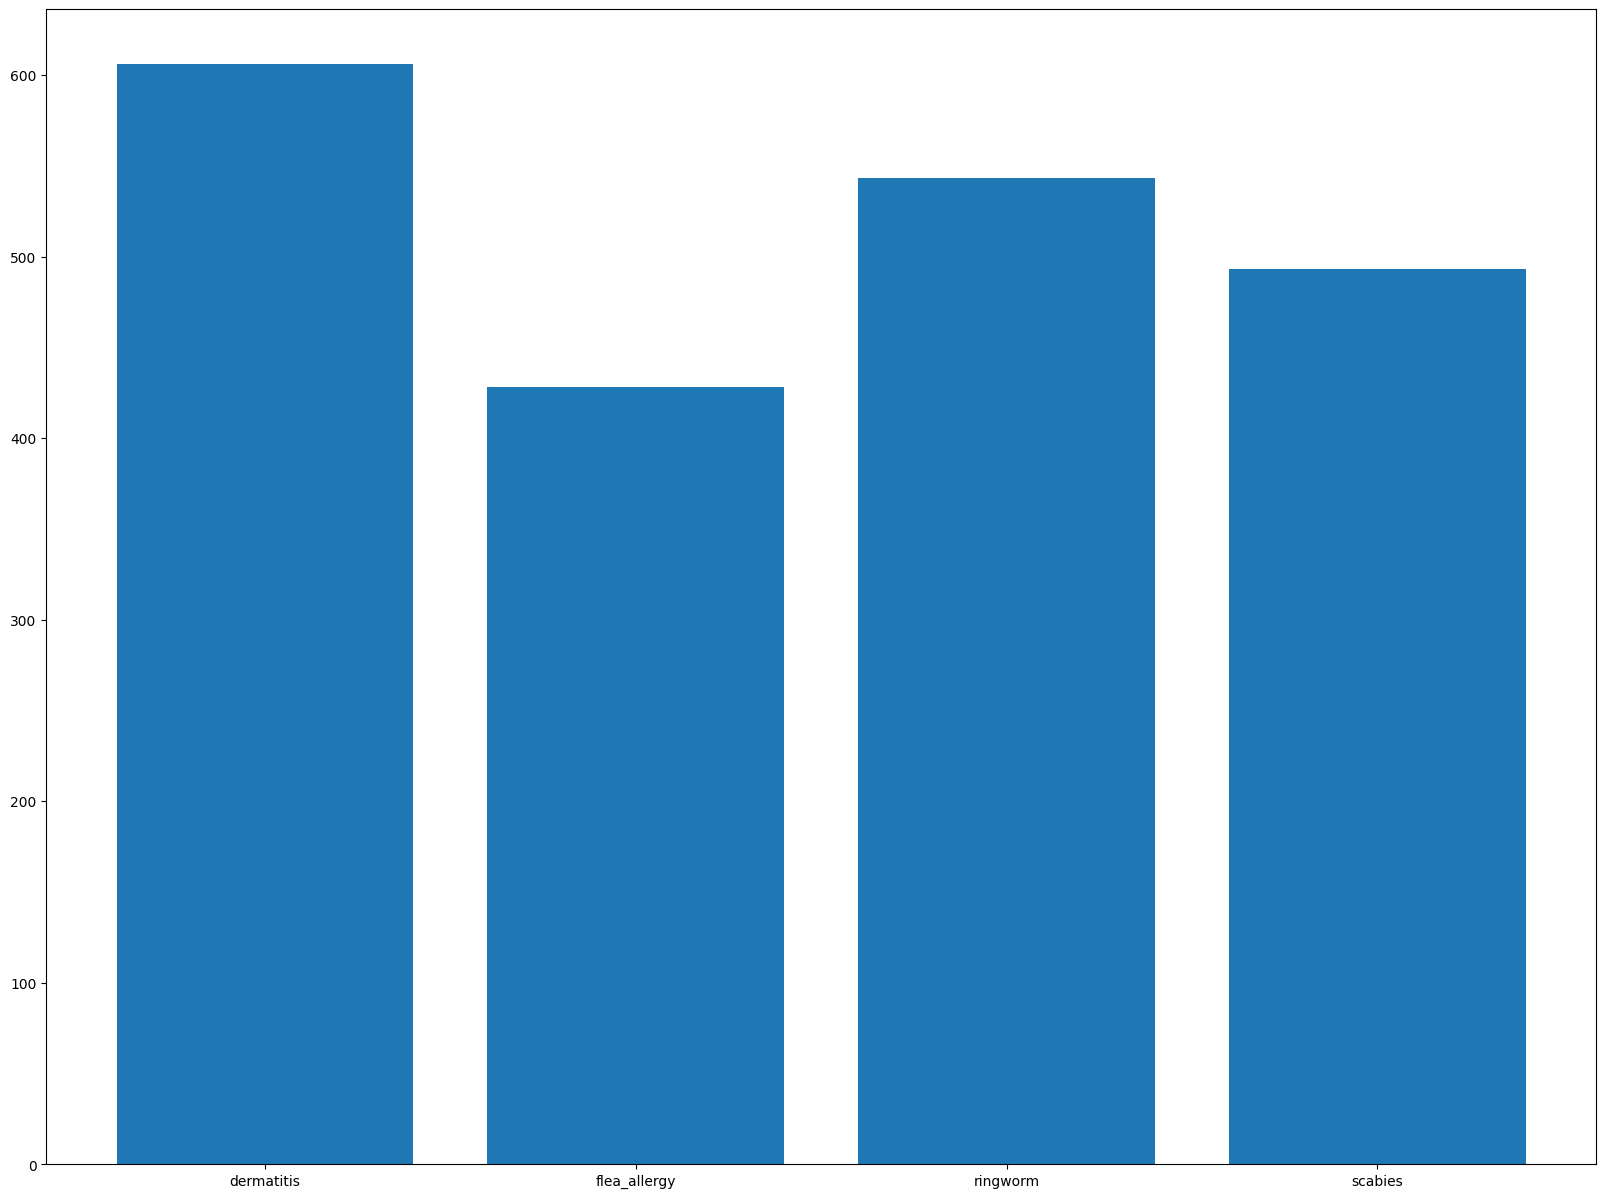

In [6]:
labels = train_generator.classes.tolist() + test_generator.classes.tolist() + valid_generator.classes.tolist()
value_counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots(figsize=(20, 15))
ax.bar(value_counts[0], value_counts[1])
ax.set_xticks(value_counts[0])
ax.set_xticklabels(list(train_generator.class_indices.keys()))
plt.show()

In [7]:
def build_model(input_shape=(224, 224, 3)):
        base_model = tf.keras.applications.Xception(
                                                include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape
                                                )
        base_model.trainable = True

        input_layer = tf.keras.layers.Input(shape=input_shape)
        x = base_model(input_layer)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        output_layer = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

        model = tf.keras.Model(
                                inputs=input_layer, 
                                outputs=output_layer
                                )

        model.compile(
                        optimizer='adam', 
                        loss='categorical_crossentropy', 
                        metrics=[
                                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc')
                                ]
                        )

        return model

In [8]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                patience=50,
                                                monitor='val_loss',
                                                restore_best_weights=True
                                                )   

history = model.fit(
                    train_generator, epochs=200,
                    validation_data = test_generator,
                    callbacks = [early_stopping]
                    )

Epoch 1/200
133/133 [==============================] - 27s 141ms/step - loss: 1.3351 - accuracy: 0.3601 - precision: 0.6444 - recall: 0.0910 - auc: 0.6178 - val_loss: 4.3967 - val_accuracy: 0.4065 - val_precision: 0.4189 - val_recall: 0.4000 - val_auc: 0.6783
Epoch 2/200
133/133 [==============================] - 17s 130ms/step - loss: 1.2937 - accuracy: 0.4310 - precision: 0.6929 - recall: 0.1217 - auc: 0.6603 - val_loss: 1.4133 - val_accuracy: 0.2774 - val_precision: 0.4091 - val_recall: 0.0581 - val_auc: 0.4842
Epoch 3/200
133/133 [==============================] - 20s 148ms/step - loss: 1.2532 - accuracy: 0.4460 - precision: 0.7365 - recall: 0.1543 - auc: 0.6808 - val_loss: 1.2256 - val_accuracy: 0.4000 - val_precision: 0.8333 - val_recall: 0.0968 - val_auc: 0.7335
Epoch 4/200
133/133 [==============================] - 19s 143ms/step - loss: 1.2462 - accuracy: 0.4247 - precision: 0.7241 - recall: 0.1581 - auc: 0.6884 - val_loss: 2.5526 - val_accuracy: 0.2839 - val_precision: 0.3506

In [13]:
model.save('artifacts/diseases.h5')

In [ ]:
history_cp = history.history.copy()
history_cp['loss'] = np.cumsum(history_cp['loss']) / np.arange(1, len(history_cp['loss']) + 1)
history_cp['val_loss'] = np.cumsum(history_cp['val_loss']) / np.arange(1, len(history_cp['val_loss']) + 1)

history_cp['accuracy'] = np.cumsum(history_cp['accuracy']) / np.arange(1, len(history_cp['accuracy']) + 1)
history_cp['val_accuracy'] = np.cumsum(history_cp['val_accuracy']) / np.arange(1, len(history_cp['val_accuracy']) + 1)

history_cp['precision'] = np.cumsum(history_cp['precision']) / np.arange(1, len(history_cp['precision']) + 1)
history_cp['val_precision'] = np.cumsum(history_cp['val_precision']) / np.arange(1, len(history_cp['val_precision']) + 1)

history_cp['recall'] = np.cumsum(history_cp['recall']) / np.arange(1, len(history_cp['recall']) + 1)
history_cp['val_recall'] = np.cumsum(history_cp['val_recall']) / np.arange(1, len(history_cp['val_recall']) + 1)

history_cp['auc'] = np.cumsum(history_cp['auc']) / np.arange(1, len(history_cp['auc']) + 1)
history_cp['val_auc'] = np.cumsum(history_cp['val_auc']) / np.arange(1, len(history_cp['val_auc']) + 1)

In [ ]:
# Plot history_cp
plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.plot(history_cp['loss'], label='loss')
plt.plot(history_cp['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 5, 2)
plt.plot(history_cp['accuracy'], label='accuracy')
plt.plot(history_cp['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 5, 3)
plt.plot(history_cp['precision'], label='precision')
plt.plot(history_cp['val_precision'], label='val_precision')
plt.legend()
plt.title('Precision')

plt.subplot(1, 5, 4)
plt.plot(history_cp['recall'], label='recall')
plt.plot(history_cp['val_recall'], label='val_recall')
plt.legend()
plt.title('Recall')

plt.subplot(1, 5, 5)
plt.plot(history_cp['auc'], label='auc')
plt.plot(history_cp['val_auc'], label='val_auc')
plt.legend()
plt.title('AUC')

plt.suptitle('Emotion Model - Training Performance')
plt.show()

### Evaluation

In [13]:
import cv2 as cv
import numpy as np
import seaborn as sns
import tensorflow as tf
from PIL import ImageFile
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [14]:
model_disease = tf.keras.models.load_model('artifacts/diseases.h5')
model_disease.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')
                        ]
                )

In [15]:
def preprocessing_function(image):
    return tf.keras.applications.xception.preprocess_input(image)
    
def inference_animal(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocessing_function(image)
    pred = model_disease.predict(
                                image,
                                verbose=0
                                ).squeeze()
    label = pred.argmax()
    return label

In [16]:
eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                preprocessing_function=preprocessing_function
                                                                )
eval_generator = eval_datagen.flow_from_directory(
                                                'data/images/test',
                                                batch_size=32,
                                                color_mode='rgb',
                                                target_size=(224, 224),
                                                class_mode='categorical',
                                                shuffle=False      
                                                )   


Found 155 images belonging to 4 classes.


In [17]:
Ytest = eval_generator.classes
Ptest = model_disease.predict(eval_generator)
Ptest = np.argmax(Ptest, axis=1)


5/5 [==============================] - 40s 6s/step


In [18]:
class_dict = eval_generator.class_indices
class_dict_rev = {v: k for k, v in class_dict.items()}
class_dict_rev

{0: 'dermatitis', 1: 'flea_allergy', 2: 'ringworm', 3: 'scabies'}

In [19]:
clf_report = classification_report(
                                    Ytest,
                                    Ptest,
                                    target_names=list(class_dict.keys())    
                                    )   
cm = confusion_matrix(Ytest, Ptest)

In [20]:
print("############### Classification Report ###############")
print(clf_report)

############### Classification Report ###############
              precision    recall  f1-score   support

  dermatitis       1.00      1.00      1.00        21
flea_allergy       1.00      1.00      1.00        22
    ringworm       1.00      1.00      1.00        90
     scabies       1.00      1.00      1.00        22

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



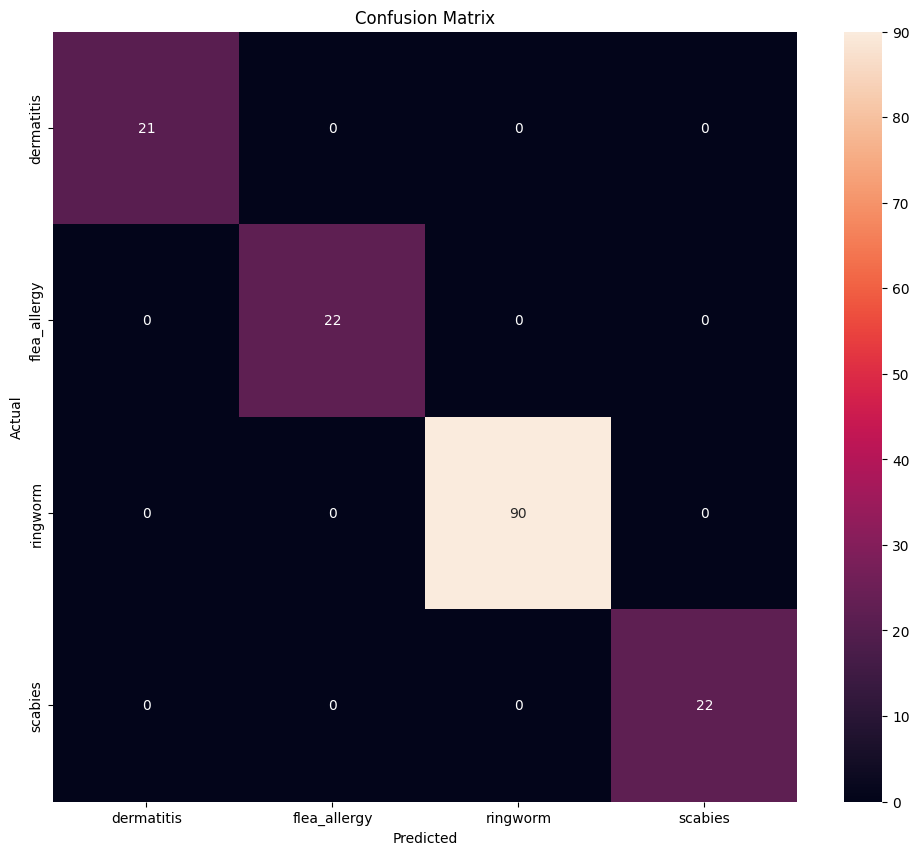

In [21]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(Ytest, Ptest)
sns.heatmap(
            cm, 
            fmt='d', 
            annot=True, 
            xticklabels=list(class_dict.keys()), 
            yticklabels=list(class_dict.keys())
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Inference

In [22]:
import os
import torch
import cv2 as cv
import numpy as np
from PIL import Image
import tensorflow as tf

In [23]:
model_disease = tf.keras.models.load_model('artifacts/diseases.h5')
model_disease.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=[
                        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')
                        ]
                )

In [30]:
def inference_disease(
                    sample_json,
                    class_dict = {
                                0: 'dermatitis',
                                1: 'flea_allergy',
                                2: 'ringworm',
                                3: 'scabies'
                                }
                    ):
        image = cv.imread(sample_json['image'])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, (224, 224))
        image = np.expand_dims(image, axis=0)
        image = tf.keras.applications.xception.preprocess_input(image)
        pred = model_disease.predict(
                                    image,
                                    verbose=0
                                    ).squeeze()
        label = int(pred.argmax())
        return class_dict[label]

In [33]:
inference_disease({
"image": "data/images/test/download.jpeg",
"ears": "flaky",
"paws_and_pads": "red",
"eyes": "normal",
"underbelly": "irritated",
"tail": "flaky",
"armpits": "irritated",
"nails": "normal",
"skin_folds": "flaky",
"overall_coat_condition": "flaky",
"dermatitis": 1,
"flea_allergy": 0,
"ringworm": 0,
"scabies": 1
})

'ringworm'